In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="darkgrid") 
sns.set_context("notebook", font_scale=1.1)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

CHECKPOINT_DIR = Path("./artifacts")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
CKPT_PATH = CHECKPOINT_DIR / "best_resnet_soil.pth"

## 1. EDA — Image dataset

In [2]:
from pathlib import Path

# Include both original and augmented image datasets
IMAGE_ROOTS = [
    Path("./data/soil_images/Orignal-Dataset"),
    Path("./data/soil_images/CyAUG-Dataset"),
]

image_paths = []
for root in IMAGE_ROOTS:
    image_paths.extend(root.glob("*/*"))

if len(image_paths) == 0:
    raise FileNotFoundError(f"No images found under {IMAGE_ROOTS} – check paths or download.")

img_records = []
for p in image_paths:
    label = p.parent.name
    img_records.append((str(p), label, p.parent.parent.name))  # filepath, label, source

img_df = pd.DataFrame(img_records, columns=["filepath", "label", "source"])
print("Image dataset shape:", img_df.shape)
print("Source split:\n", img_df["source"].value_counts())
print("Label counts:\n", img_df["label"].value_counts())
print("Sample rows:")
display(img_df.sample(5, random_state=0))

Image dataset shape: (6286, 3)
Source split:
 source
CyAUG-Dataset      5097
Orignal-Dataset    1189
Name: count, dtype: int64
Label counts:
 label
Yellow_Soil      1470
Black_Soil       1428
Red_Soil         1235
Alluvial_Soil     745
Arid_Soil         568
Laterite_Soil     438
Mountain_Soil     402
Name: count, dtype: int64
Sample rows:


,filepath,label,source
4230,data\soil_images\CyAUG-Dataset\Red_Soil\r (409...,Red_Soil,CyAUG-Dataset
4292,data\soil_images\CyAUG-Dataset\Red_Soil\r (465...,Red_Soil,CyAUG-Dataset
3362,data\soil_images\CyAUG-Dataset\Laterite_Soil\1...,Laterite_Soil,CyAUG-Dataset
2434,data\soil_images\CyAUG-Dataset\Black_Soil\b (1...,Black_Soil,CyAUG-Dataset
5883,data\soil_images\CyAUG-Dataset\Yellow_Soil\y (...,Yellow_Soil,CyAUG-Dataset


## 2. EDA — Tabular datasets

In [3]:
d = pd.read_csv('./data/tabular/d1.csv')

In [4]:
d['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [5]:
d.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.00,2200.00,2200.00,2200.00,2200.00,2200.00,2200.00
mean,50.55,53.36,48.15,25.62,71.48,6.47,103.46
std,36.92,32.99,50.65,5.06,22.26,0.77,54.96
min,0.00,5.00,5.00,8.83,14.26,3.50,20.21
25%,21.00,28.00,20.00,22.77,60.26,5.97,64.55
50%,37.00,51.00,32.00,25.60,80.47,6.43,94.87
75%,84.25,68.00,49.00,28.56,89.95,6.92,124.27
max,140.00,145.00,205.00,43.68,99.98,9.94,298.56


In [6]:
d.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.88,82.00,6.50,202.94,rice
1,85,58,41,21.77,80.32,7.04,226.66,rice
2,60,55,44,23.00,82.32,7.84,263.96,rice
3,74,35,40,26.49,80.16,6.98,242.86,rice
4,78,42,42,20.13,81.60,7.63,262.72,rice


In [7]:
d_numeric = d.select_dtypes(include='number')

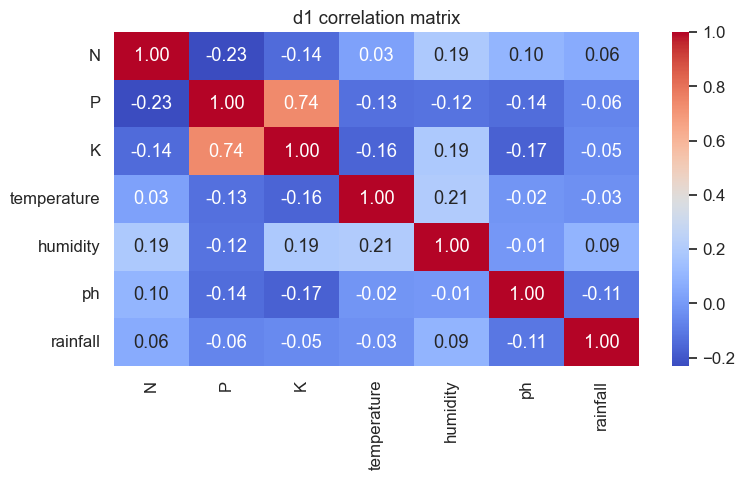

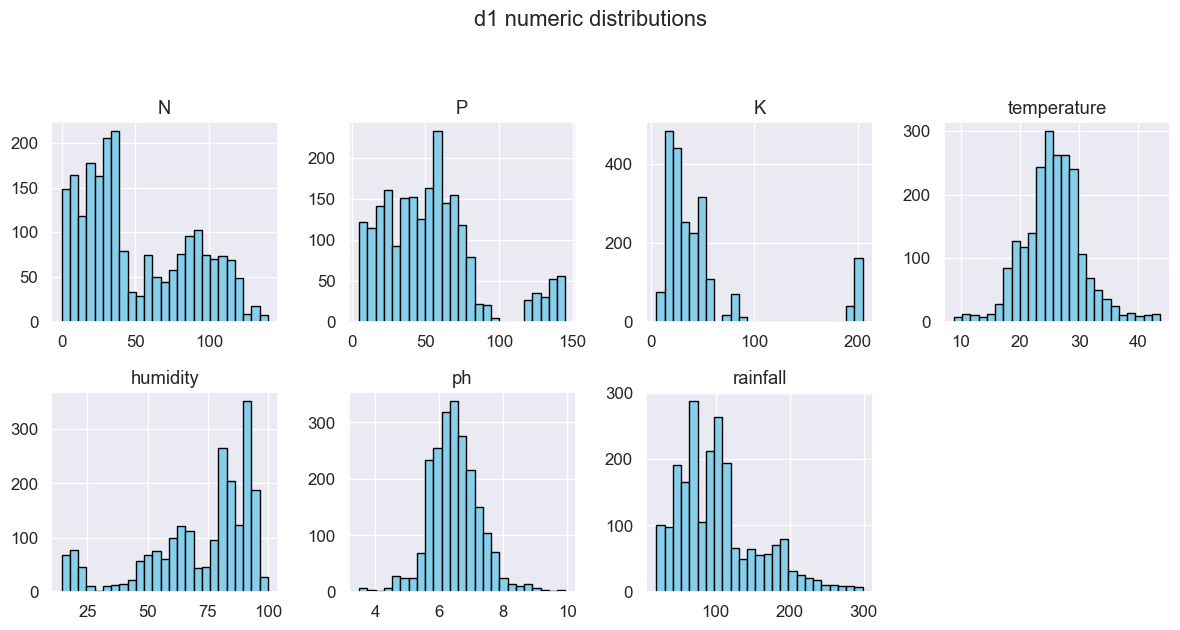

In [8]:
corr = d_numeric.corr()
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
ax.set_title('d1 correlation matrix')
plt.tight_layout()
plt.show()

d_numeric.hist(bins=25, figsize=(12, 6), layout=(2, 4), color='skyblue', edgecolor='black')
plt.suptitle('d1 numeric distributions', y=1.05)
plt.tight_layout()
plt.show()

## 3. Image model: soil-type classifier
We train a ResNet50 on the soil image dataset and keep the best checkpoint for downstream soil-type inference.

In [9]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(
    img_df,
    test_size=0.2,                  # 20% for test
    stratify=img_df["label"],       # ensure class distribution is maintained in splits
    random_state=42,                # fixed seed for reproducibility
)
val_rel = 0.1 / 0.8  # 10% of total reserved for val

train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_rel,
    stratify=train_val_df["label"],
    random_state=42,
)

# Create class mappings for image labels
class_names = sorted(img_df["label"].unique())
class_to_idx = {c: i for i, c in enumerate(class_names)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
num_classes = len(class_names)

print('Class names:', class_names)
print("Class to index mapping:", class_to_idx)
print("Number of classes:", num_classes)


print({"train": len(train_df), "val": len(val_df), "test": len(test_df)})

Class names: ['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 'Mountain_Soil', 'Red_Soil', 'Yellow_Soil']
Class to index mapping: {'Alluvial_Soil': 0, 'Arid_Soil': 1, 'Black_Soil': 2, 'Laterite_Soil': 3, 'Mountain_Soil': 4, 'Red_Soil': 5, 'Yellow_Soil': 6}
Number of classes: 7
{'train': 4399, 'val': 629, 'test': 1258}


In [10]:
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

IMAGE_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),                                    # Makes all images the same size so the model can process them together
    transforms.RandomHorizontalFlip(),                                              # Flips images sideways to help the model learn from different angles
    transforms.RandomVerticalFlip(),                                                # Flips images upside down to create more variety in the training data
    transforms.ColorJitter(brightness=0.1, contrast=0.1),                           # Slightly changes lighting/colors to handle different photo conditions
    transforms.ToTensor(),                                                          # Converts the image into a mathematical format the model understands
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),    # Standardizes pixel values to help the model learn faster and more stably
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),                                    # Resize to match the training size so the model sees the same scale
    transforms.ToTensor(),                                                          # Convert to numbers (tensors) for the model to read
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),    # Use the same math scaling as training for consistency
])

# Custom class to load images and labels from our dataframe
# It tells PyTorch how to read an image file and get its corresponding label.
class SoilImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["filepath"]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = class_to_idx[row["label"]]
        return image, label

train_dataset = SoilImageDataset(train_df, transform=train_transform)
val_dataset = SoilImageDataset(val_df, transform=val_test_transform)
test_dataset = SoilImageDataset(test_df, transform=val_test_transform)

NUM_WORKERS = 0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Device: cpu


In [11]:
from copy import deepcopy
import time
from sklearn.metrics import classification_report, confusion_matrix


def train_image_model(num_epochs=5, lr=1e-3):
    # Initialize a pre-trained ResNet50 model and replace the final layer 
    # to match the number of soil classes in our dataset.
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    # Define how we measure error (Loss) and how we update the model (Optimizer).
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_wts = deepcopy(model.state_dict())
    best_val_acc = 0.0

    # If we already have a saved "best" model, load it instead of training from scratch.
    if CKPT_PATH.exists():
        model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
        print("Loaded ResNet50 checkpoint from", CKPT_PATH)
        return model

    # Main training loop: repeat the process for a set number of 'epochs' (full passes over data).
    for epoch in range(num_epochs):
        start = time.time()
        
        # Training Phase: Feed images to the model, calculate errors, and adjust weights.
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double().item() / len(train_loader.dataset)

        # Validation Phase: Test the model on unseen data to see how well it generalizes.
        model.eval()
        val_corrects = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels)
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double().item() / len(val_loader.dataset)

        # Progress Tracking: Print performance and save the model if it's the best one so far.
        elapsed = time.time() - start
        print(f"Epoch {epoch+1}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.3f} | val loss {val_loss:.4f} acc {val_acc:.3f} | {elapsed:.1f}s")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_wts = deepcopy(model.state_dict())

    # Restore the best weights found during training and return the final model.
    model.load_state_dict(best_wts)
    return model

image_model = train_image_model(num_epochs=5, lr=1e-3)

Loaded ResNet50 checkpoint from artifacts\best_resnet_soil.pth


In [53]:
# Evaluate on held-out test set
image_model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = image_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())

print("Test classification report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=class_names, 
    yticklabels=class_names, 
    ax=ax,
    linewidths=0.5,
    annot_kws={"size": 10}
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Image model confusion matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

## 4. Tabular Model: Crop Recommender

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


def preprocess_tabular(df):
    # Separate the data into 'features' (the input info) and 'labels' (the crop we want to predict).
    X = df.drop(columns=["label"]).copy()
    y = df["label"].copy()

    # Convert crop names (text) into numbers so the computer can process them.
    label_encoder = LabelEncoder()
    y_enc = label_encoder.fit_transform(y)

    # Identify columns that contain text or categories instead of numbers.
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

    # For each text column, convert the categories into unique numbers.
    feat_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        feat_encoders[col] = le

    # Fill in any missing data points with the 'middle' (median) value of that column 
    # to keep the dataset complete without introducing bias.
    medians = X.median(numeric_only=True)
    X = X.fillna(medians)
    
    # Ensure all final data is in a decimal (float) format for the XGBoost model.
    X = X.astype(float)

    return X, y_enc, label_encoder, feat_encoders, medians, cat_cols


Training XGBoost (rows=2200):
validation accuracy: 0.993

Classification report:

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       1.00      1.00      1.00        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.90      0.95        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.95      1.00      0.98        20
    mungbean       0.95      1.00      0.98        20
   muskmelon       1.00      1.00      1.00        2

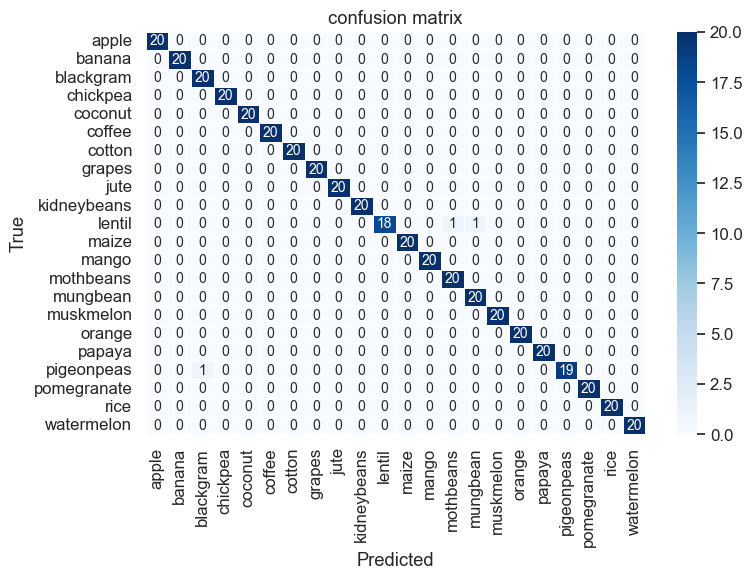

In [13]:
df = d
print(f"\nTraining XGBoost (rows={df.shape[0]}):")

# 1. Clean and prepare the data using our preprocessing function.
X, y_enc, label_encoder, feat_encoders, medians, cat_cols = preprocess_tabular(df)

# 2. Split the data into a 'Training' set (to learn from) and a 'Validation' set (to test on).
X_train, X_val, y_train, y_val = train_test_split(
    X.values,
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc,
)

# 3. Balance the data by giving more importance to rare crops so the model doesn't ignore them.
#    Using the formula: weight = total_samples / (num_classes * class_count) to adjust weights
classes, counts = np.unique(y_enc, return_counts=True)
class_weights = {cls: len(y_enc) / (len(classes) * count) for cls, count in zip(classes, counts)}
train_weights = np.array([class_weights[c] for c in y_train])

# 4. Set up the XGBoost model with certain hyperparameters for learning.
num_classes = len(label_encoder.classes_)
clf = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=2,
    gamma=0.1,
    objective="multi:softprob",
    num_class=num_classes,
    eval_metric=["mlogloss", "merror"],
    tree_method="hist",
    random_state=42,
)

# 5. Train the model using the training data and weights.
clf.fit(
    X_train,
    y_train,
    sample_weight=train_weights,
    eval_set=[(X_val, y_val)],
    verbose=False,
)

# 6. Test the model on the validation set and print how accurate it is.
y_pred = clf.predict_proba(X_val).argmax(axis=1)
acc = accuracy_score(y_val, y_pred)
print(f"validation accuracy: {acc:.3f}")
print("\nClassification report:\n")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

# 7. Visualize the results with a heatmap (Confusion Matrix) to see where the model gets confused.
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax, linewidths=0.5, annot_kws={"size": 10})
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title(f"confusion matrix")
plt.tight_layout()
plt.show()

# 8. Save the model and all the "tools" (encoders, medians) needed to use it later.
meta = {
    "label_encoder": label_encoder,
    "feat_encoders": feat_encoders,
    "medians": medians,
    "cat_cols": cat_cols,
    "feature_order": X.columns.tolist(),
}

xgb_model = {"model": clf, "meta": meta}

## 4. Complete pipline
Classify soil type from the image, predict top-K crops suitable for the given geological and environmental conditions, and the by using knowledge based domain, verify whether the recommended can be grown on the given soil.

In [ ]:
SOIL_TYPE_DOMAIN_KNOWLEDGE = {
    "Alluvial_Soil": [
        "rice", "maize", "cotton", "jute", "pigeonpeas", "mungbean", "blackgram", "lentil", 
        "chickpea", "kidneybeans", "pomegranate", "banana", "mango", "grapes", "watermelon", 
        "muskmelon", "apple", "orange", "papaya", "coconut", "coffee"
    ],

    "Black_Soil": [
        "cotton", "maize", "pigeonpeas", "mungbean", "blackgram", "lentil", "chickpea", 
        "kidneybeans", "mothbeans", "orange", "papaya"
    ],
    
    "Red_Soil": [
        "cotton", "rice", "maize", "pigeonpeas", "mungbean", "blackgram", "lentil", 
        "chickpea", "kidneybeans", "mothbeans", "pomegranate", "banana", "mango", 
        "grapes", "watermelon", "muskmelon", "apple", "orange", "papaya", "coconut", "coffee"
    ],
    
    "Laterite_Soil": [
        "coffee", "coconut", "rice", "maize", "pigeonpeas", "mungbean", "blackgram", 
        "lentil", "chickpea", "kidneybeans", "pomegranate", "banana", "mango", "grapes", "watermelon", 
        "muskmelon", "apple", "orange", "papaya"
    ],
    
    "Arid_Soil": [
        "maize", "cotton", "pigeonpeas", "mungbean", "blackgram", "lentil", 
        "chickpea", "kidneybeans", "mothbeans", "pomegranate", "banana", "mango", "grapes", 
        "watermelon", "muskmelon", "apple", "orange", "papaya"
    ],
    
    "Mountain_Soil": [
        "coffee", "maize", "rice", "pigeonpeas", "mungbean", "blackgram", 
        "lentil", "chickpea", "kidneybeans", "pomegranate", "banana", "mango", "grapes", 
        "watermelon", "muskmelon", "apple", "orange", "papaya"
    ],
    
    "Yellow_Soil": [
        "rice", "cotton", "jute", "pigeonpeas", "mungbean", "blackgram", 
        "lentil", "chickpea", "kidneybeans", "pomegranate", "banana", "mango", "grapes", 
        "watermelon", "muskmelon", "apple", "orange", "papaya", "coconut", "coffee"
    ]
}

In [73]:
import torch.nn.functional as F

# Valid ranges for environmental parameters 
# representing physical or reasonable agricultural limits (w.r.t domain knowledge)
PRECONDITIONS = {
    "N": (0, 150), 
    "P": (5, 150), 
    "K": (5, 210), 
    "temperature": (10, 50), 
    "humidity": (10, 100), 
    "ph": (3.5, 9.5), 
    "rainfall": (20, 3100)
}

# Check if the provided environmental data makes sense (e.g., pH isn't 14).
def check_preconditions(features):
    reasons = []
    for key, (min_val, max_val) in PRECONDITIONS.items():
        if key in features:
            val = features[key]
            if val < min_val or val > max_val:
                reason = "high" if val > max_val else "low"
                reasons.append(f"{key} out of range -> cannot recommend, {key} too {reason}")
    return reasons

# Use the trained image model to identify the soil type from a photo.
def predict_soil_type(image_path):
    image_model.eval()
    image = Image.open(image_path).convert("RGB")
    tensor = val_test_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = image_model(tensor)
        probs = F.softmax(logits, dim=1)
        pred_idx = probs.argmax(dim=1).item()
        pred_conf = probs.max().item()
    return idx_to_class[pred_idx], pred_conf

# Helper to convert text categories into the numbers the model was trained on.
def encode_categorical(value, encoder):
    value = str(value)
    classes = list(encoder.classes_)
    if value in classes:
        return encoder.transform([value])[0]
    return encoder.transform([classes[0]])[0]

# Format the raw environmental data into the exact shape and format the XGBoost model expects.
def prepare_tabular_input(features):
    meta = xgb_model["meta"]
    feature_order = meta["feature_order"]
    cat_cols = set(meta["cat_cols"])
    feat_encoders = meta["feat_encoders"]
    medians = meta["medians"]

    row = {}
    for col in feature_order:
        if col in features:
            row[col] = features[col]
        else:
            row[col] = medians[col] if col in medians else 0

    row_df = pd.DataFrame([row])

    for col in cat_cols:
        row_df[col] = row_df[col].astype(str).apply(lambda v: encode_categorical(v, feat_encoders[col]))

    for col in feature_order:
        if col not in row_df.columns:
            default_val = medians[col] if col in medians else 0
            row_df[col] = default_val

    row_df = row_df[feature_order]
    row_df = row_df.fillna(medians)
    row_df = row_df.astype(float)
    return row_df.values

# The main RS combines soil identification and crop prediction 
# to give a final recommendation, verified against domain knowledge.
def recommend_crop(image_path, tabular_features, dataset_name="d1", top_k=22):
    # 1. Validate inputs
    precondition_errors = check_preconditions(tabular_features)
    if precondition_errors:
        return {
            "error": True,
            "reasons": precondition_errors
        }

    # 2. Identify soil from image
    soil_label, soil_conf = predict_soil_type(image_path)

    # 3. Predict best crops from environmental data
    sample_x = prepare_tabular_input(tabular_features)
    model = xgb_model["model"]
    label_encoder = xgb_model["meta"]["label_encoder"]

    proba = model.predict_proba(sample_x)[0]
    top_indices = proba.argsort()[::-1][:top_k]
    top_crops = label_encoder.inverse_transform(top_indices)
    top_probs = proba[top_indices]

    # 4. Cross-reference predictions with soil compatibility (Domain Knowledge)
    compatible_crops = SOIL_TYPE_DOMAIN_KNOWLEDGE.get(soil_label, [])
    compatible_crops_lower = [c.lower() for c in compatible_crops]
    
    final_recommendations = []
    for crop, prob in zip(top_crops, top_probs):
        is_compatible = crop.lower() in compatible_crops_lower
        final_recommendations.append({
            "crop": crop,
            "probability": float(prob),
            "is_compatible_with_soil": is_compatible
        })

    return {
        "soil_prediction": soil_label,
        "soil_confidence": soil_conf,
        "top_recommendations": final_recommendations,
        "tabular_dataset_used": dataset_name,
    }

## 5. Final testing 

In [74]:
print("--- Test 1: Valid Features ---")
example_image_path = "./data/soil_images/Orignal-Dataset/Black_Soil/1.jpg" 
base_features = d.drop(columns=['label']).median(numeric_only=True).to_dict()
result = recommend_crop(example_image_path, base_features, dataset_name='d1', top_k=5)

if "error" in result:
    print("Error:", result["reasons"])
else:
    print(f"Predicted Soil Type: {result['soil_prediction']} (Conf: {result['soil_confidence']:.2f})")
    print("Top Crop Recommendations:")
    for rec in result['top_recommendations']:
        status = "Compatible" if rec['is_compatible_with_soil'] else "Soil Mismatch"
        print(f"- {rec['crop']} ({rec['probability']:.2%}) -> {status}")

print("\n--- Test 2: Invalid Features ---")
invalid_features = base_features.copy()
invalid_features["ph"] = 12.0
invalid_features["temperature"] = 5.0

result_invalid = recommend_crop(example_image_path, invalid_features)
if "error" in result_invalid:
    for r in result_invalid["reasons"]:
        print(f"Caught expected error: {r}")



--- Test 1: Valid Features ---


Predicted Soil Type: Black_Soil (Conf: 1.00)
Top Crop Recommendations:
- muskmelon (7.21%) -> Soil Mismatch
- chickpea (6.29%) -> Compatible
- grapes (5.83%) -> Soil Mismatch
- apple (5.59%) -> Soil Mismatch
- orange (5.50%) -> Compatible

--- Test 2: Invalid Features ---
Caught expected error: temperature out of range -> cannot recommend, temperature too low
Caught expected error: ph out of range -> cannot recommend, ph too high
